In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.votable import parse_single_table
from sklearn.linear_model import RANSACRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.interpolate import UnivariateSpline
from astropy.io import fits
from scipy.ndimage import uniform_filter1d
from scipy.ndimage import rank_filter
from PyAstronomy import pyasl
from scipy.signal import find_peaks


# Tarea 3

## Parte 1 
Extraccion de datos

In [ ]:
import os
from astropy.io import fits
import tarfile



archivos = os.listdir("archive")

adp_files = [f for f in archivos if "ADP" in f and f.endswith(".fits")]

print("Archivos ADP encontrados:", adp_files)
ruta = os.path.join("archive", adp_files[0])
with fits.open(ruta) as hdul:
    hdul.info()
  


# Abrir FITS

hdul = fits.open(ruta)
header = hdul[0].header
sn_values = []
for i in range(20,101): # Corregimos esto p
    key = f"HIERARCH ESO DRS SPE EXT SN{i}"
    try:
        sn = header[key]
        sn_values.append(sn)
    except KeyError:
        # Si no existe el SNi, simplemente saltar
        continue

# Convertir a array y calcular promedio
sn_values = np.array(sn_values)
sn_mean = np.mean(sn_values)

print("Todos los SN encontrados:", sn_values)
print("Promedio de S/N:", sn_mean)
print("Error: " , np.std(sn_values))

print(header["SNR"])



Archivos ADP encontrados: ['ADP.2018-03-28T01_03_35.906.fits', 'ADP.2018-03-28T01_03_35.920.fits', 'ADP.2018-03-28T01_03_35.928.fits', 'ADP.2018-03-28T01_03_35.942.fits', 'ADP.2018-03-28T01_03_35.950.fits', 'ADP.2018-03-28T01_03_36.000.fits', 'ADP.2018-03-28T01_03_36.002.fits', 'ADP.2019-04-16T01_15_17.980.fits', 'ADP.2019-04-16T01_15_17.982.fits', 'ADP.2019-04-16T01_15_17.984.fits', 'ADP.2019-04-16T01_15_17.986.fits', 'ADP.2019-04-16T01_15_17.988.fits', 'ADP.2019-04-16T01_15_17.990.fits', 'ADP.2019-04-16T01_15_18.024.fits', 'ADP.2019-04-16T01_15_18.026.fits', 'ADP.2019-04-16T01_15_18.028.fits', 'ADP.2019-04-16T01_15_18.030.fits', 'ADP.2019-04-16T01_15_18.036.fits', 'ADP.2019-04-16T01_15_18.204.fits', 'ADP.2019-04-16T01_15_18.206.fits', 'ADP.2019-04-16T01_15_18.208.fits', 'ADP.2019-04-16T01_15_18.210.fits', 'ADP.2019-04-16T01_15_18.212.fits', 'ADP.2019-04-16T01_15_18.214.fits', 'ADP.2019-04-16T01_15_18.216.fits', 'ADP.2019-04-16T01_15_18.218.fits', 'ADP.2019-04-27T01_12_26.157.fits', '

In [ ]:

sn_values = []

# Recorrer todos los ADP FITS
for fits_file in adp_files:
    hdul = fits.open("archive/"+fits_file)
    header = hdul[0].header
    
    # Leer S/N directo del header
    try:
        sn = header["SNR"]  
        #if header["OBJECT"] == "SW1502-0301":
        #    sn = 0  # Forzar S/N a 0 para este objeto
    except KeyError:
        sn = 0  # si no existe
    
    sn_values.append(float(sn))
    hdul.close()
    

# Encontrar el índice del espectro con mayor S/N
best_index = np.argmax(sn_values)
best_fits = adp_files[best_index]

print("Mejor FITS según S/N:", best_fits)
print("S/N:", sn_values[best_index])



# No se porque este objeto esta aqui: SW1502-0301

Mejor FITS según S/N: ADP.2018-03-28T01_03_35.950.fits
S/N: 186.55


In [ ]:

mask = np.array(sn_values) > 90 # Cambié a > 90 para incluir más espectros
adp_files_w_mask = np.array(adp_files)[mask]

Filename: archive\ADP.2023-06-06T01_06_36.487.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    3092   ()      
  1  SPECTRUM      1 BinTableHDU     46   1R x 3C   [313011D, 313011E, 313011E]   


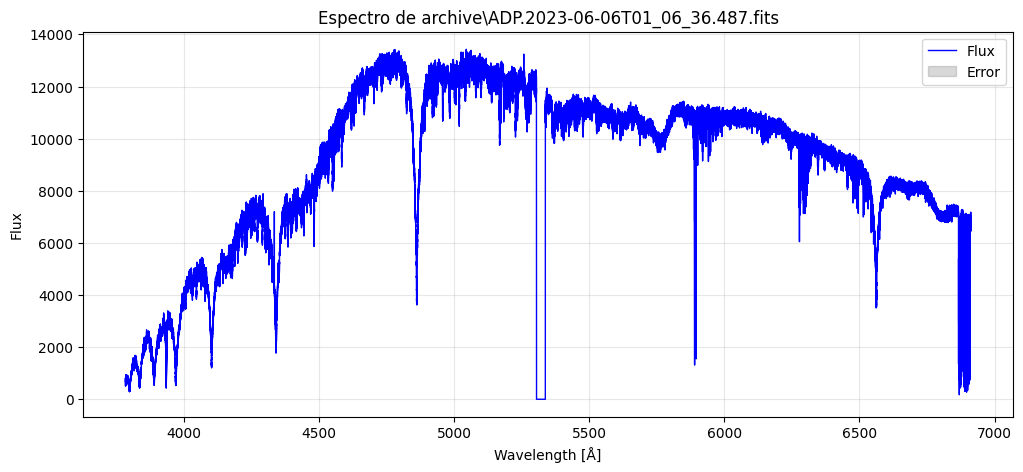

In [ ]:


best_fits = "archive\ADP.2023-06-06T01_06_36.487.fits" #"archive/ADP.2018-03-28T01_03_35.950.fits"
hdul = fits.open(best_fits)
hdul.info()

data = hdul[1].data
header = hdul[0].header
wavelength = data[0][0]  # o data[0]
flux       = data[0][1] # o data[1]
error      = data[0][2]  # o data[2]

plt.figure(figsize=(12,5))
plt.plot(wavelength, flux, color='blue', lw=1, label='Flux')
plt.fill_between(wavelength, flux-error, flux+error, color='gray', alpha=0.3, label='Error', )
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux")
plt.title(f"Espectro de {best_fits}")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

hdul.close()


In [5]:
print(repr(header))

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2023-06-05T02:51:45.851'     / UT date when this file was written    
INSTRUME= 'HARPS   '                    / Instrument used.                      
RA      =           225.684392          / 15:02:44.2 RA (J2000) pointing (deg)  
DEC     =             -3.03099          / -03:01:51.5 DEC (J2000) pointing (deg)
EQUINOX =                2000.          / Standard FK5 (years)                  
RADECSYS= 'FK5     '                    / Coordinate reference frame            
EXPTIME =             199.99

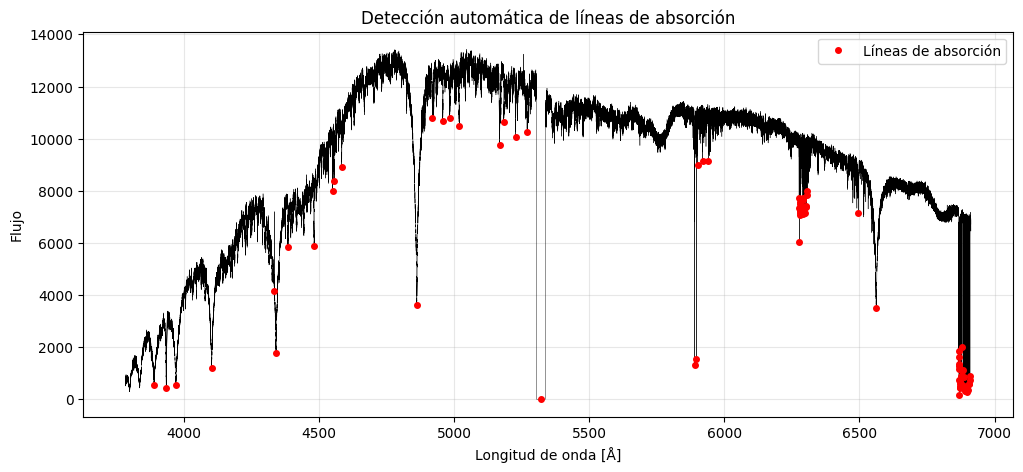

Se detectaron 81 líneas de absorción.


In [ ]:

wavelength = data[0][0]  
flux       = data[0][1]  

# Invertimos el espectro para buscar los mínimos como peaks
inverted_flux = -flux

# Buscar mínimos locales (picos en el flujo invertido)
# 'prominence' controla qué tan profundas deben ser las líneas para ser consideradas reales
peaks, properties = find_peaks(inverted_flux, prominence=2000)

# Extraer las posiciones de las líneas de absorción
abs_lines = wavelength[peaks]

plt.figure(figsize=(12,5))
plt.plot(wavelength, flux, color='black', lw=0.3)
plt.plot(wavelength[peaks], flux[peaks], 'ro', markersize=4, label='Líneas de absorción')
plt.xlabel("Longitud de onda [Å]")
plt.ylabel("Flujo")
plt.title("Detección automática de líneas de absorción")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Se detectaron {len(abs_lines)} líneas de absorción.")



In [7]:
print("Líneas de absorción detectadas (Å): ", abs_lines)

Líneas de absorción detectadas (Å):  [3888.79 3933.49 3968.8  4101.45 4333.72 4340.16 4384.16 4481.09 4549.2
 4554.71 4583.25 4861.   4919.13 4957.   4983.   5018.38 5167.66 5182.95
 5226.59 5269.65 5320.5  5889.68 5895.65 5901.18 5919.37 5940.81 6276.52
 6277.02 6277.8  6278.59 6278.81 6279.6  6280.11 6280.89 6281.67 6289.93
 6291.87 6292.67 6294.88 6295.67 6298.17 6298.94 6301.71 6302.48 6305.52
 6306.27 6495.56 6561.93 6866.91 6867.23 6867.91 6868.23 6868.59 6868.78
 6869.64 6870.63 6870.97 6871.93 6872.52 6873.48 6874.34 6875.27 6876.4
 6877.32 6878.72 6879.61 6883.52 6885.44 6886.42 6888.63 6889.59 6892.05
 6892.99 6895.72 6896.65 6899.64 6900.55 6903.8  6904.71 6908.22 6909.12]


Líneas identificadas dentro de ±0.8 Å:

3888.79 Å → Hζ (3889.05 Å)
3933.49 Å → Ca II K (3933.7 Å)
3968.80 Å → Ca II H (3968.5 Å)
4101.45 Å → Hδ (4101.7 Å)
4340.16 Å → Hγ (4340.5 Å)
4861.00 Å → Hβ (4861.3 Å)
5167.66 Å → Mg I b3 (5167.3 Å)
5269.65 Å → Fe I (5270 Å)
5889.68 Å → Na I D2 (5889.95 Å)
5895.65 Å → Na I D1 (5895.92 Å)


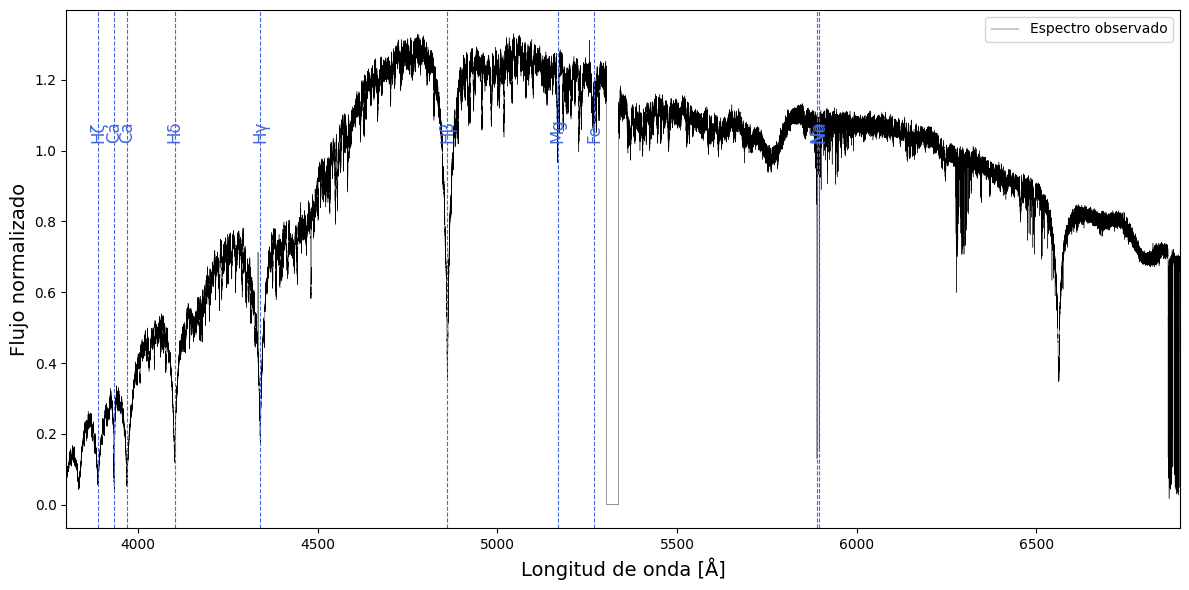

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ======================


# ======================
# BASE DE DATOS ATÓMICA SIMPLE (en Å)
# ======================
known_lines = {
    "Hα (6562.8 Å)": 6562.8,
    "Hβ (4861.3 Å)": 4861.3,
    "Hγ (4340.5 Å)": 4340.5,
    "Hδ (4101.7 Å)": 4101.7,
    "Ca II K (3933.7 Å)": 3933.7,
    "Ca II H (3968.5 Å)": 3968.5,
    "Na I D1 (5895.92 Å)": 5895.92,
    "Na I D2 (5889.95 Å)": 5889.95,
    "Mg I b1 (5183.6 Å)": 5183.6,
    "Mg I b2 (5172.7 Å)": 5172.7,
    "Mg I b3 (5167.3 Å)": 5167.3,
    "Fe I (5270 Å)": 5270.0,
    "Fe I (5328 Å)": 5328.0,
    "Fe I (5405 Å)": 5405.0,
    "O I (6300 Å)": 6300.3,
    "He I (5875.6 Å)": 5875.6,

    "Hη (3835.38 Å)": 3835.38,
    "Hζ (3889.05 Å)": 3889.05,
    "Hε (3970.07 Å)": 3970.07,
}

# ======================
# TOLERANCIA
# ======================
tol = 0.6  # Å

# ======================
# BUSCAR COINCIDENCIAS
# ======================
matches = []
for line in abs_lines:
    found = None
    for name, ref in known_lines.items():
        if abs(line - ref) <= tol:
            found = name
            break
    matches.append((line, found))

# Mostrar coincidencias encontradas
print("Líneas identificadas dentro de ±0.8 Å:\n")
for lam, name in matches:
    if name:
        print(f"{lam:.2f} Å → {name}")

# ======================
# GRAFICAR RESULTADOS
# ======================
plt.figure(figsize=(12,6))
plt.plot(wavelength, flux/np.median(flux), color='k', lw=0.3, label='Espectro observado')

for lam, name in matches:
    if name:
        plt.axvline(lam, color='royalblue', ls='--', lw=0.8, alpha=1)
        plt.text(lam, 1.02, name.split()[0], rotation=90, va='bottom', ha='center', fontsize=12, color='royalblue')

plt.xlabel("Longitud de onda [Å]", fontsize=14)
plt.ylabel("Flujo normalizado", fontsize=14)
plt.xlim(3800, 6900)
plt.legend()
plt.tight_layout()
plt.show()


<!-- ## Parte 2 -->


Líneas identificadas dentro de ±0.6 Å:

3888.79 Å → Hζ (3889.05 Å)
3933.49 Å → Ca II K (3933.7 Å)
3968.80 Å → Ca II H (3968.5 Å)
4101.45 Å → Hδ (4101.7 Å)
4340.16 Å → Hγ (4340.5 Å)
4861.00 Å → Hβ (4861.3 Å)
5167.66 Å → Mg I b3 (5167.3 Å)
5269.65 Å → Fe I (5270 Å)
5889.68 Å → Na I D2 (5889.95 Å)
5895.65 Å → Na I D1 (5895.92 Å)


C:\Users\Maxlo\AppData\Local\Temp\ipykernel_28564\3039715084.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


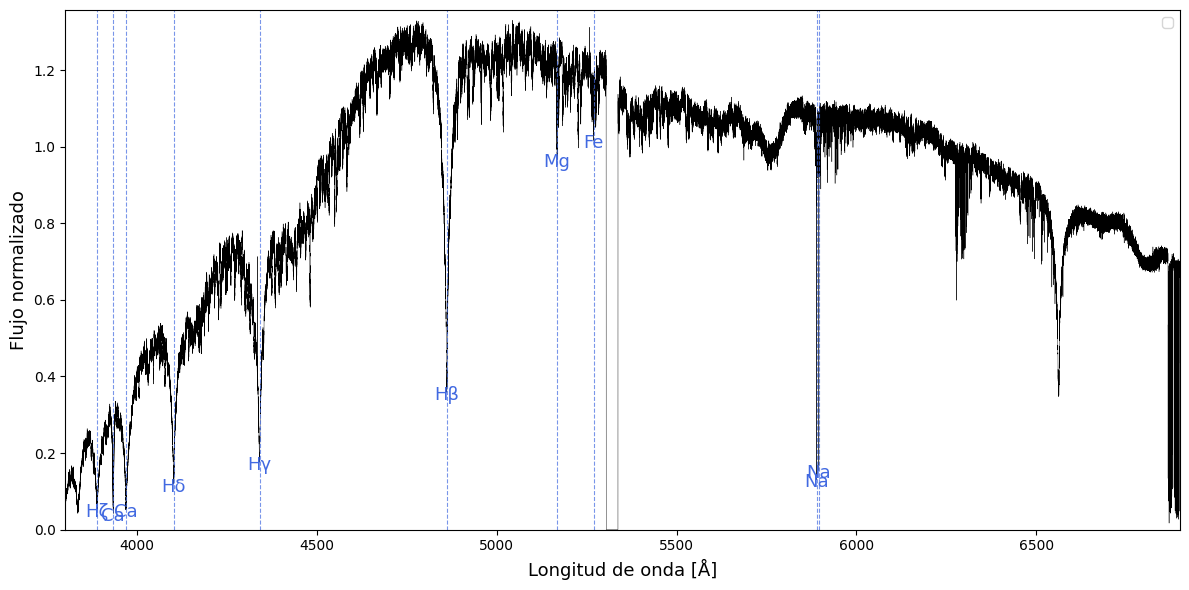

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

tol = 0.6  # Å

# ======================
# BUSCAR COINCIDENCIAS
# ======================
matches = []
for line in abs_lines:
    found = None
    for name, ref in known_lines.items():
        if abs(line - ref) <= tol:
            found = name
            break
    matches.append((line, found))

# Mostrar coincidencias
print("Líneas identificadas dentro de ±0.6 Å:\n")
for lam, name in matches:
    if name:
        print(f"{lam:.2f} Å → {name}")

# ======================
# GRAFICAR RESULTADOS
# ======================
plt.figure(figsize=(12,6))
plt.plot(wavelength, flux/np.median(flux), color='k', lw=0.3)

flux_norm = flux / np.median(flux)

for lam, name in matches:
    if name:
        # Encontrar índice más cercano en el eje de longitud de onda
        idx = np.argmin(np.abs(wavelength - lam))
        # Posicionar el texto justo sobre el flujo en ese punto
        y_text = flux_norm[idx] - 0.03  # un poco arriba
        plt.axvline(lam, color='royalblue', ls='--', lw=0.8, alpha=0.7)
        plt.text(lam, y_text, name.split()[0],
                 rotation=0, va='bottom', ha='center',
                 fontsize=13, color='royalblue')

plt.xlabel("Longitud de onda [Å]", fontsize=13)
plt.ylabel("Flujo normalizado", fontsize=13)
plt.xlim(3800, 6900)
plt.ylim(flux_norm.min()*0.98, flux_norm.max()*1.02)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\Maxlo\AppData\Local\Temp\ipykernel_28564\4173574552.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


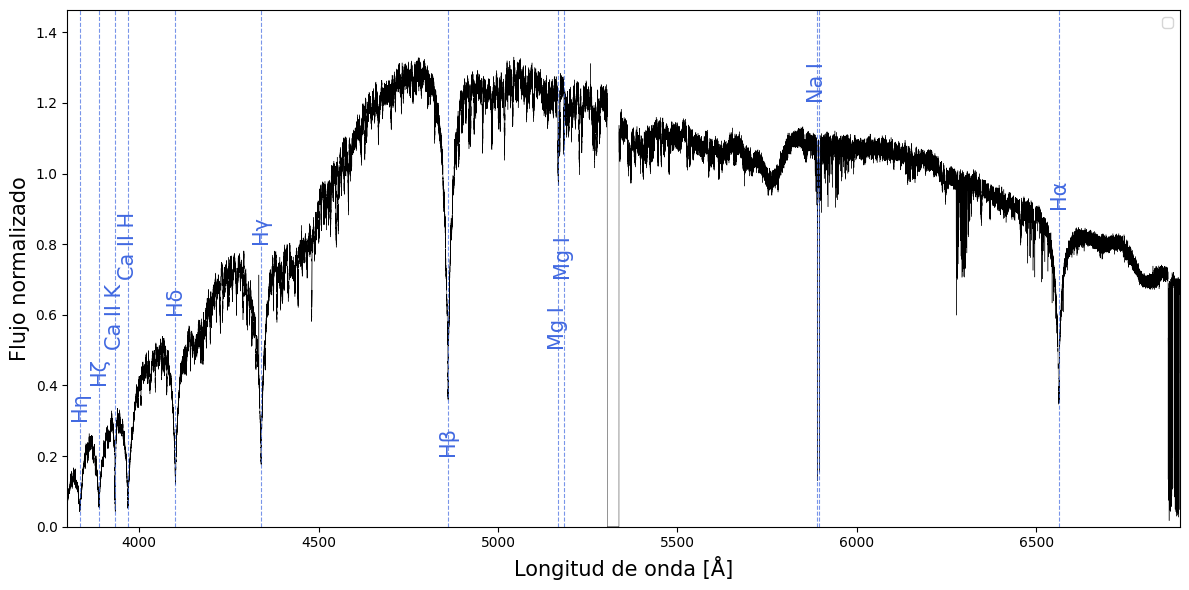

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


label_heights = {
    3834.87: 0.3,
    3888.80: 0.4,
    3933.49: 0.5,
    3968.28: 0.7,
    4101.34: 0.6,
    4340.09: 0.8,
    4861.00: 0.2,
    5167.90: 0.5,
    5183.08: 0.7,
    5889.68: 1.2,
    5895.66: 1.15,
    6562.20: 0.9,
}


matches = [
    (3834.87, "Hη"),
    (3888.80, "Hζ"),
    (3933.49, "Ca II K"),
    (3968.28, "Ca II H"),
    (4101.34, "Hδ"),
    (4340.09, "Hγ"),
    (4861.00, "Hβ"),
    (5167.90, "Mg I"),
    (5183.08, "Mg I"),
    (5889.68, "Na I"),
    (5895.66, ""),
    (6562.20, "Hα"),
]

# ======================
# Graficar
# ======================
plt.figure(figsize=(12,6))
flux_norm = flux / np.median(flux)
plt.plot(wavelength, flux_norm, color='k', lw=0.3)

for lam, name in matches:
    idx = np.argmin(np.abs(wavelength - lam))
    y_base = flux_norm[idx]
    y_text = label_heights.get(lam, 1.02)  
    
    plt.axvline(lam, color='royalblue', ls='--', lw=0.8, alpha=0.7)
    plt.text(lam, y_text, name, rotation=90,
             va='bottom', ha='center', fontsize=15, color='royalblue')

plt.xlabel("Longitud de onda [Å]", fontsize=15)
plt.ylabel("Flujo normalizado", fontsize=15)
plt.xlim(3800, 6900)
plt.ylim(flux_norm.min()*0.95, flux_norm.max()*1.1)
plt.legend()
plt.tight_layout()
plt.savefig("espectro_identificado.png", dpi=300)
plt.show()


In [18]:
import pickle

file = 'MASTER DE RASSINE\Master_spectrum_2025-10-27T053105.p'

with open(file, 'rb') as f:
    master = pickle.load(f)

master.keys()

wave = np.arange(master["wave_min"], master["wave_max"] , master["dwave"])
flux = master["flux"]

In [16]:
import pickle

file = 'MASTER DE RASSINE\RASSINE_Master_spectrum_2025-10-27T053105.p'

with open(file, 'rb') as f:
    master = pickle.load(f)

master.keys()

wave = master["wave"]
flux = master["flux"]

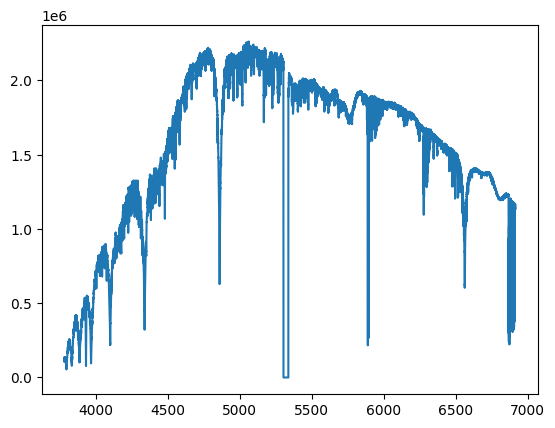

In [19]:
plt.plot(wave,flux)

### Escalar y calibrar (iSpec)

### Creacion del template

### Efectos baricentricos y de rotacion de la tierra

In [ ]:
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.time import Time
from astropy.constants import c
from astropy.units import km, s

coord = SkyCoord(ra=225.684717, dec=-3.03035, unit='deg')
obs_time = Time(str(adp_files[100][4:-5].replace('_', ':')))  
print(EarthLocation.get_site_names())  # para ver opciones
location = EarthLocation.of_site('La Silla Observatory (ESO)') 

v_corr = coord.radial_velocity_correction(obstime=obs_time, location=location)
v_corr = v_corr.to(km/s)



['ALMA', 'AO', 'ARCA', 'ASKAP', 'ATA', 'ATCA', 'ATST', 'Allen Telescope Array', 'Anderson Mesa', 'Anglo-Australian Observatory', 'Apache Point', 'Apache Point Observatory', 'Arecibo', 'Arecibo Observatory', 'Astroparticle Research with Cosmics in the Abyss', 'Atacama Large Millimeter Array', 'Australia Telescope Compact Array', 'Australian Square Kilometre Array Pathfinder', 'BAO', 'BBSO', 'Beijing XingLong Observatory', 'Big Bear Solar Observatory', 'Black Moshannon Observatory', 'CAHA', 'CAHA', 'CHARA', 'CHIME', 'Canada-France-Hawaii Telescope', 'Canadian Hydrogen Intensity Mapping Experiment', 'Catalina Observatory', 'Catalina Observatory: 61 inch telescope', 'Centro Astronomico Hispano-Aleman, Almeria', 'Cerro Armazones Observatory', 'Cerro Pachon', 'Cerro Paranal', 'Cerro Tololo', 'Cerro Tololo Interamerican Observatory', 'Cima Ekar 182 cm Telescope', 'Cima Ekar Observing Station', 'Ckoirama', 'Ckoirama Observatory', 'DCT', 'DKIST', 'DRAO', 'DRAO 26m Telescope', 'Daniel K. Inouye 

In [12]:
print(v_corr)

-14.153679808131725 km / s


In [13]:
print(flux[100], len(error))
new_error = [err for err in error if err == err]

565.9563 313011


In [14]:
print(new_error)

[]


Columnas disponibles: ('WAVE', 'FLUX', 'ERR')


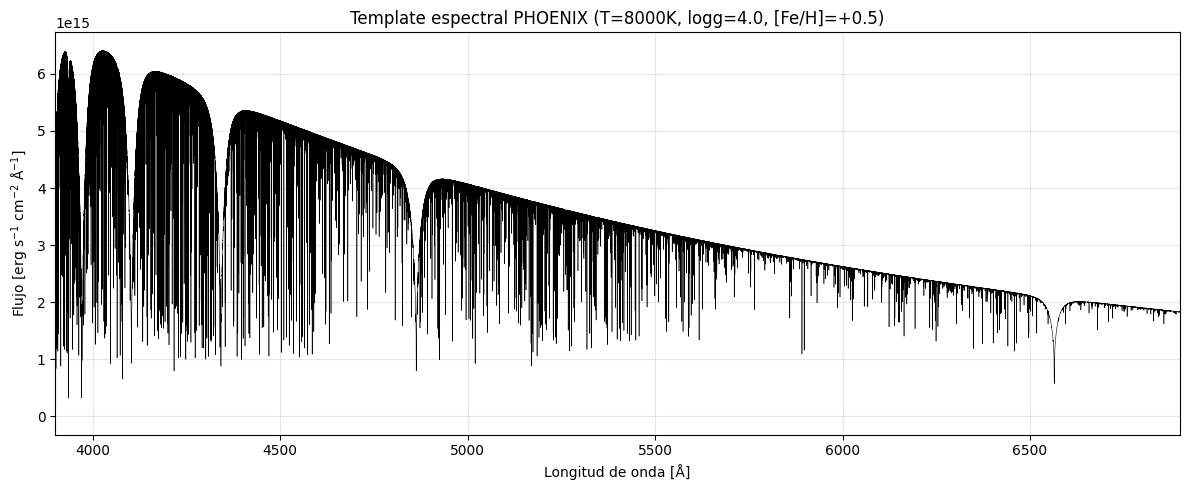

In [ ]:
from astropy.io.votable import parse_single_table
import matplotlib.pyplot as plt
import numpy as np

file = "Templates\lte08000-4.00-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits"

hdul = fits.open(file)
flux = hdul[0].data
wave_file = "Templates\WAVE_PHOENIX-ACES-AGSS-COND-2011.fits"

hdul_wave = fits.open(wave_file)
wavelength = hdul_wave[0].data
hdul.close()
hdul_wave.close()


# Ver nombres de columnas
print("Columnas disponibles:", data.dtype.names)


# Graficar
plt.figure(figsize=(12,5))
plt.plot(wavelength, flux, color='black', lw=0.4)
plt.xlabel("Longitud de onda [Å]")
plt.ylabel("Flujo [erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$]")
plt.title("Template espectral PHOENIX (T=8000K, logg=4.0, [Fe/H]=+0.5)")
plt.grid(alpha=0.3)
plt.xlim(3900, 6900)
plt.tight_layout()
plt.show()



In [ ]:
## Maldita funcion te odio, te hice bacan y alfinal ocupe solo el polinomio, que mierda.

def fit_continuum(wave, flux, regions, method = "polinomio",grado=7,s=0.002, window=100, perc=95):
    mask_total = np.zeros_like(wave, dtype=bool)
    for r in regions:
        mask_total |= (wave >= r[0]) & (wave <= r[1])
    wave_cont = wave#[mask_total]
    flux_cont = flux#[mask_total]

    if method == "polinomio":
        coeffs = np.polyfit(wave_cont, flux_cont, grado)
        continuum = np.polyval(coeffs, wave)

    if method == "pipeline":
         # Crear pipeline polinomial
        model = make_pipeline(PolynomialFeatures(grado), LinearRegression())
        # Ajustar modelo
        model.fit(wave_cont.reshape(-1, 1), flux_cont)
        # Evaluar en todo el rango de longitud de onda
        continuum = model.predict(wave.reshape(-1, 1))

    if method == "RANSAC":
        X = PolynomialFeatures(grado).fit_transform(wave_cont.reshape(-1, 1))
        model = RANSACRegressor().fit(X, flux_cont)
        continuum = model.predict(PolynomialFeatures(grado).fit_transform(wave.reshape(-1, 1)))

    if method == "spline":
        spline = UnivariateSpline(wave_cont, flux_cont, s=s)
        continuum = spline(wave)
        
    if method == "percentil":
        rank = int((perc/100) * (window-1))
        continuum = uniform_filter1d(flux_cont, size=window)
    
           
    return continuum


## PROBANDO CON TEMPLATE DE Granada HRES Library    TENEMOS GANADOOOOOOR


ahora solo vamos a considerar los de 4670 a 5130 angstrom para que tenemos una aproximacion mas grande en crosscorr


SIMPLE  =                    T / Fits standard                                  BITPIX  =                  -64 / Bits per pixel                                 NAXIS   =                    1 / Number of axes                                 NAXIS1  =                37508 / Axis length                                    EXTEND  =                    T / File may contain extensions                    ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        DATE    = '2005-06-17T17:39:46' / Date FITS file was generated                  IRAF-TLM= '19:39:45 (17/06/2005)' / Time of last modification                   COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H WAT0_001= 'system=equispec'                                                     WAT1_001= 'wtype=linear label=Wavelength units=Angstroms'                       WCSDIM  =                    2 /1 /3    

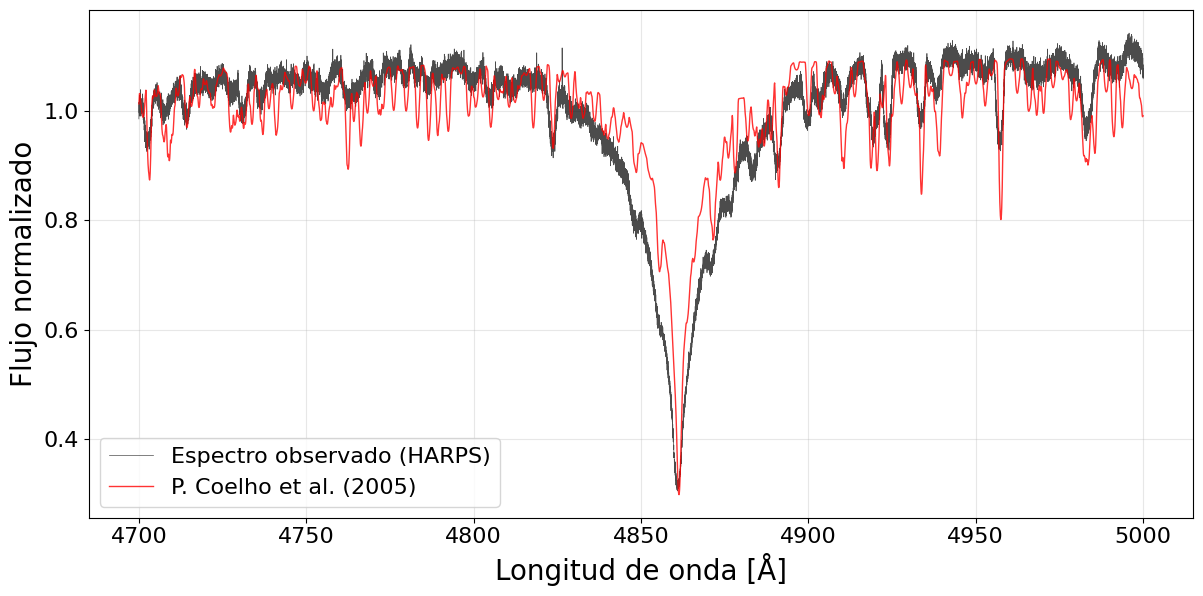

In [ ]:
###
#Hola ayudantes ahora van a ver el desastre.
###

spec_HARPS = "archive\ADP.2023-06-05T01_02_22.525.fits"
#"archive\ADP.2023-06-07T01_04_24.567.fits" #"archive/ADP.2018-03-28T01_03_35.950.fits"

hdul = fits.open(spec_HARPS)
data = hdul[1].data
wavelength = data[0][0]  
flux       = data[0][1] 
Date       = hdul[0].header["DATE"]
hdul.close()

file = "Templates\CoelhoK8000g3.5FeH0.2.fits.xml"
votable = parse_single_table(file)
data = votable.array


wavelength_tpl = data['WAVELENGTH']   
flux_tpl = data['FLUX']              

hdul = fits.open("Templates\R_50.0_6750_40_p02p00.ms.fits")
header = hdul[0].header

NAXIS1  = header['NAXIS1']
CRVAL1  = header['CRVAL1']
CDELT1  = header['CDELT1']
wavelength_tpl = CRVAL1 + CDELT1 * np.arange(NAXIS1)
flux_tpl = hdul[0].data
print(header)


regions = [(5400, 6500), (4930, 5270), (4400, 4790), (4010, 4070), (3790, 3920), (6610, 6860),(4150, 4270)]
regions_templ = [(3810, 3820), (3855, 3870), (3910, 3920), (3940, 3960) , (3990, 4090), (4120, 4320) , (4400,4800) , (5000, 5750), (6000,6400), (6750, 8000)]


wavelength_mask_harps = (wavelength > 4700) & (wavelength < 5000)
wavelength = wavelength[wavelength_mask_harps]
flux = flux[wavelength_mask_harps]

wavelength_mask_template = (wavelength_tpl > 4700) & (wavelength_tpl < 5000)
wavelength_tpl = wavelength_tpl[wavelength_mask_template]
flux_tpl = flux_tpl[wavelength_mask_template]



cont_obs = fit_continuum(wavelength, flux, regions, method="polinomio", grado = 1, s=0.1)
cont_tpl = fit_continuum(wavelength_tpl, flux_tpl, regions_templ, method="polinomio", grado=1, s = 0.1)

cont_tpl_ransac = fit_continuum(wavelength_tpl, flux_tpl, regions_templ, method="RANSAC", grado=1, s = 0.1)
cont_obs_ransca = fit_continuum(wavelength, flux, regions, method="RANSAC", grado = 1, s=0.1)


flux_norm = flux / cont_obs
flux_tpl_norm = flux_tpl / cont_tpl

flux_norm_ransac = flux /cont_obs_ransca
flux_tpl_norm_ransacr  = flux_tpl / cont_tpl_ransac

mask_tpl = (wavelength_tpl >= 3900) & (wavelength_tpl <= 5300) | (wavelength_tpl >= 5340) & (wavelength_tpl <= 5900) | (wavelength_tpl >=5980 ) & (wavelength_tpl <= 6285)| (wavelength_tpl >= 6330) & (wavelength_tpl <= 6800)
mask_harps = (wavelength >= 3900) & (wavelength <= 5300) | (wavelength >= 5340) & (wavelength <= 5900) | (wavelength >=5980 ) & (wavelength <= 6285)| (wavelength >= 6330) & (wavelength <= 6800)


wavelength_tpl = wavelength_tpl#[mask_tpl]
flux_tpl_norm = flux_tpl_norm#[mask_tpl]
wavelength = wavelength#[mask_harps]
flux_norm = flux_norm#[mask_harps]
flux_tpl_norm_ransacr = flux_tpl_norm#[mask_tpl]
    
        #flux_norm = np.array([1.24 if fn >=1.24 else fn for fn in flux_norm])


plt.figure(figsize=(12,6))
plt.plot(wavelength, flux_norm, color='black', lw=0.5, alpha=0.7,label='Espectro observado (HARPS)')
plt.plot(wavelength_tpl, flux_tpl_norm, color='red', lw=1, alpha=0.8, label='P. Coelho et al. (2005)')
plt.xlabel("Longitud de onda [Å]", fontsize=20)
plt.ylabel("Flujo normalizado", fontsize=20)
plt.legend(fontsize=16)
#plt.xlim(3800, 6900)
#plt.ylim(0,1.5)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("Imagenes/espectro_vs_template.png", dpi=300)
plt.show()


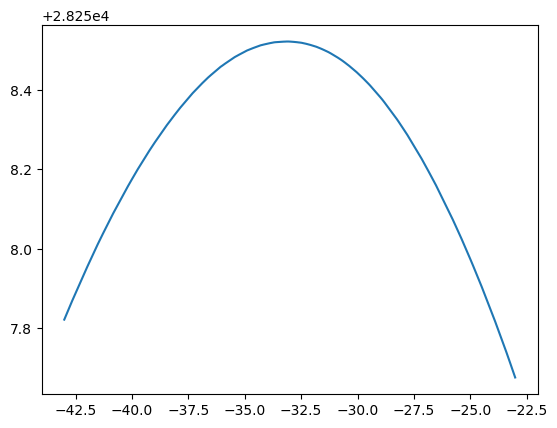

-33.09000000000197 28258.522579821452


NameError: name 'p' is not defined

In [ ]:
from scipy.interpolate import interp1d
import numpy as np


# finalmente no ocupe la interpolacion.
interp_tpl = interp1d(
    wavelength_tpl, flux_tpl_norm,
    kind='linear', bounds_error=False, fill_value=np.nan
)

# Interpolar al eje del observado
flux_tpl_interp = interp_tpl(wavelength)

# Crear máscara de valores válidos (sin NaN)
mask = ~np.isnan(flux_tpl_interp)

# Aplicar la máscara
wave_common = wavelength[mask]
flux_obs_common = flux_norm[mask]
flux_tpl_common = flux_tpl_interp[mask]


rv, cc = pyasl.crosscorrRV(wavelength, flux_norm, wavelength_tpl, flux_tpl_norm, -33-10, -33+10, 0.01, skipedge=1000, mode="doppler")

plt.plot(rv,cc)
plt.show()
print(rv[np.argmax(cc)], np.max(cc))  


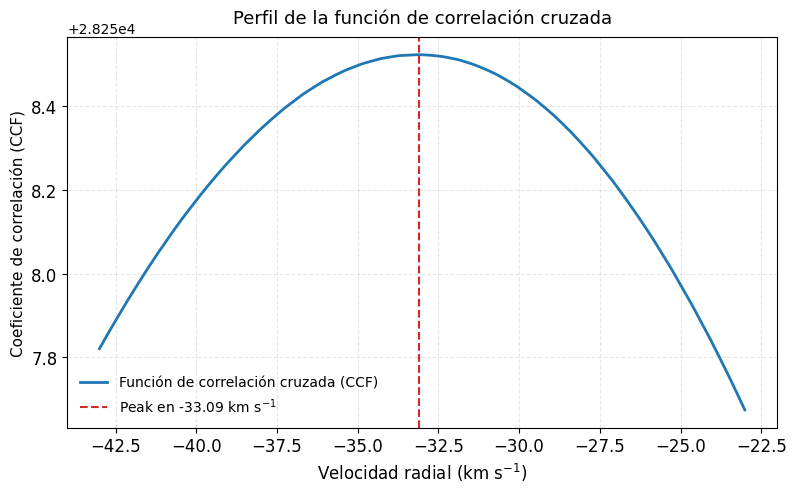

Velocidad radial estimada: -33.09 km/s
Valor máximo de la correlación: 28258.5226


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl

rv, cc = pyasl.crosscorrRV(
    wavelength, flux_norm,
    wavelength_tpl, flux_tpl_norm,
    -33 - 10, -33 + 10, 0.01,
    skipedge=1000, mode="doppler"
)

v_peak = rv[np.argmax(cc)]
cc_peak = np.max(cc)

plt.figure(figsize=(8, 5))
plt.plot(rv, cc, color="tab:blue", lw=2, label="Función de correlación cruzada (CCF)")
plt.axvline(v_peak, color="tab:red", ls="--", lw=1.5, label=fr"Peak en {v_peak:.2f} km s$^{{-1}}$")
plt.title("Perfil de la función de correlación cruzada", fontsize=13, pad=10)
plt.xlabel("Velocidad radial (km s$^{-1}$)", fontsize=12)
plt.ylabel("Coeficiente de correlación (CCF)", fontsize=11)
plt.legend(frameon=False, fontsize=10)
plt.grid(alpha=0.3, ls="--")
plt.tight_layout()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()
print(f"Velocidad radial estimada: {v_peak:.2f} km/s")
print(f"Valor máximo de la correlación: {cc_peak:.4f}")


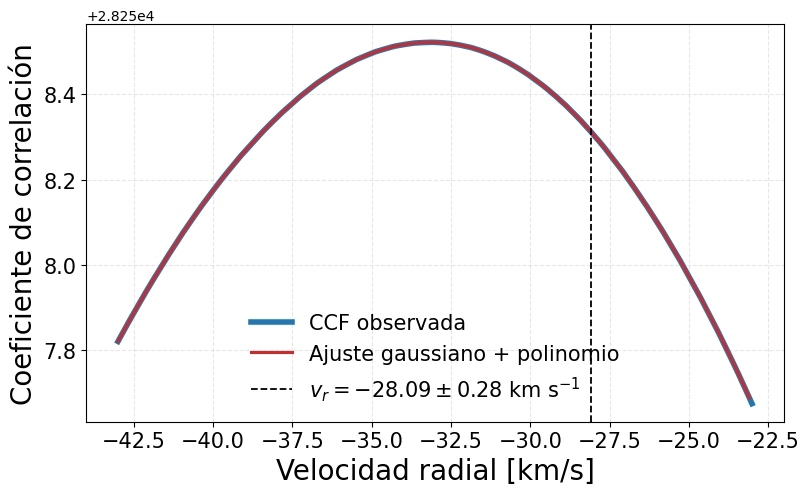

Velocidad radial medida: -28.090 ± 0.278 km/s


In [ ]:

import matplotlib.pyplot as plt

## hay que correr los bloques anteriores para tener rv y cc
## ademas de correr el bloque donde defino fit_ccf

results = fit_ccf(rv, cc, window=10, poly_order=1)

v0 = results['v0']
err_v0 = results['err_v0']
v_fit = results['v_fit']
ccf_fit = results['ccf_fit']

plt.figure(figsize=(8, 5))

plt.plot(rv, cc, color="tab:blue", lw=4, label="CCF observada")

plt.plot(v_fit, ccf_fit, color="tab:red", lw=2.2,ls = "-", label="Ajuste gaussiano + polinomio")

plt.axvline(v0, color="k", ls="--", lw=1.3,
            label=fr"$v_r = {v0:.2f} \pm {err_v0:.2f}$ km s$^{{-1}}$")

plt.xlabel("Velocidad radial [km/s]", fontsize=20)
plt.ylabel("Coeficiente de correlación", fontsize=20)
plt.legend(frameon=False, fontsize=15)
plt.grid(alpha=0.3, ls="--")
plt.tight_layout()
plt.savefig("Imagenes/ccf_ajustada.png", dpi=300)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

print(f"Velocidad radial medida: {v0:.3f} ± {err_v0:.3f} km/s")


In [ ]:
import pandas as pd


ruta = "Templates\ptemplate_sun.txt"


df = pd.read_csv(
    ruta,
    sep=r'\s+',          
    comment='=',         
    engine='python'      
)



## PROBANDO CON TEMPLATE DE PHOENIX

Finalmente no lo hice ocn phoenix, lo hice con el de coehlo


In [ ]:
import numpy as np
from scipy.optimize import curve_fit

# modelo: polinomio de grado n + gaussiana
def model(v, A, v0, sigma, *poly_coeffs):
    n = len(poly_coeffs)
    poly = sum(poly_coeffs[i]*v**i for i in range(n))
    gauss = A * np.exp(-0.5*((v - v0)/sigma)**2)
    return poly + gauss


def fit_ccf(v, ccf, window=10.0, poly_order=1):
    """
    Ajusta una gaussiana + polinomio al pico del CCF y estima
    un error más realista para la velocidad radial.

    Parámetros:
    ------------
    v : array
        Velocidades (km/s)
    ccf : array
        Valores de la correlación cruzada
    window : float
        Semiancho (km/s) del rango de ajuste alrededor del máximo
    poly_order : int
        Orden del polinomio para el fondo (0 o 1 típicamente)

    Retorna:
    ---------
    dict con v0, err_v0, sigma, fwhm, amplitude, etc.
    """

    # 1) máximo del CCF
    imax = np.argmax(ccf)
    v0_guess = v[imax]

    # 2) recorte del rango de ajuste
    mask = (v >= v0_guess - window) & (v <= v0_guess + window)
    v_fit = v[mask]
    ccf_fit = ccf[mask]

    # 3) valores iniciales
    A_guess = np.max(ccf_fit) - np.median(ccf_fit)
    sigma_guess = window / 4.0
    p0 = [A_guess, v0_guess, sigma_guess] + [np.median(ccf_fit), 0.0][:poly_order+1]

    lower = [0.0, v0_guess - 5.0, 0.05] + [-np.inf]*(poly_order+1)
    upper = [np.inf, v0_guess + 5.0, 50.0] + [ np.inf]*(poly_order+1)

    # 4) ajuste gaussiano + fondo
    popt, pcov = curve_fit(lambda vv, A, v0, sigma, *poly: model(vv, A, v0, sigma, *poly),
                           v_fit, ccf_fit, p0=p0, bounds=(lower, upper))
    perr = np.sqrt(np.diag(pcov))

    A, v0, sigma = popt[0], popt[1], popt[2]
    err_v0 = perr[1]
    fwhm = 2.0*np.sqrt(2*np.log(2))*sigma

    # Calcular SNR del pico del CCF (Tonry & Davis)
    mask_wings = (v < v0 - window) | (v > v0 + window)
    noise = np.std(ccf[mask_wings]) if np.any(mask_wings) else np.std(ccf)
    R = (A / noise) if noise > 0 else 1.0

    # Error empírico tipo Tonry-Davis
    err_td = (3.0/8.0) * (fwhm / (1.0 + R))

    # Combinar ambos (promedio cuadrático)
    err_v0_final = np.sqrt(err_v0**2 + err_td**2)


    results = {
        'v0': float(v0),
        'err_v0': float(err_v0_final),
        'sigma': float(sigma),
        'fwhm': float(fwhm),
        'amplitude': float(A),
        'R': float(R),
        'err_td': float(err_td),
        'popt': popt,
        'pcov': pcov,
        'v_fit': v_fit,
        'ccf_fit': ccf_fit
    }

    return results


# como lo puedo ocupar:
# res = fit_ccf(rv, cc, window=20, poly_order=1)
# print("Velocidad radial (km/s):", res['v0'].round(2), "±", res['err_v0'].round(2))


In [ ]:
## Esta es otra funcion complicada que esta obsoleta, solo la ocupe para graficar mas abajo pero no lo agregue a la tarea

def ajustar_continuo(wave, flux, regions=None, method="polinomio", grado=4, s=0, lam=1e5, p=0.01, ax=None):
    """
    Ajusta el continuo espectral usando distintos métodos:
    'polinomio', 'spline', 'interp', 'ALS', 'pybaselines', 'specutils'
    """

    # --- Selección de puntos de continuo ---
    if regions:
        mask_total = np.zeros_like(wave, dtype=bool)
        for r in regions:
            mask_total |= (wave >= r[0]) & (wave <= r[1])
        wave_cont = wave[mask_total]
        flux_cont = flux[mask_total]
    else:
        wave_cont, flux_cont = wave, flux

    # --- Ajustes ---
    if method == "polinomio":
        coeffs = np.polyfit(wave_cont, flux_cont, grado)
        continuum = np.polyval(coeffs, wave)

    if method == "pipeline":
         # Crear pipeline polinomial
        model = make_pipeline(PolynomialFeatures(grado), LinearRegression())
        # Ajustar modelo
        model.fit(wave_cont.reshape(-1, 1), flux_cont)
        # Evaluar en todo el rango de longitud de onda
        continuum = model.predict(wave.reshape(-1, 1))

    if method == "RANSAC":
        X = PolynomialFeatures(grado).fit_transform(wave_cont.reshape(-1, 1))
        model = RANSACRegressor().fit(X, flux_cont)
        continuum = model.predict(PolynomialFeatures(grado).fit_transform(wave.reshape(-1, 1)))

    if method == "spline":
        spline = UnivariateSpline(wave_cont, flux_cont, s=s)
        continuum = spline(wave)
        
    if method == "specutils":
        from specutils import Spectrum1D
        from specutils.fitting import fit_generic_continuum
        import astropy.units as u
        spec = Spectrum1D(spectral_axis=wave * u.AA, flux=flux * u.Unit('adu'))
        cont_fit = fit_generic_continuum(spec)
        continuum = cont_fit(wave * u.AA).value

    # --- Graficar ---
    if ax is None:
        plt.figure(figsize=(12, 5))
        ax = plt.gca()

    ax.plot(wave, flux, color='k', lw=0.6, label='Espectro HARPS')
    ax.plot(wave, continuum, lw=5, label=f'Continuo ({method})', color="red")
    if regions:
        ax.scatter(wave_cont, flux_cont, color='blue', s=10, label='Puntos del continuo')
    ax.set_xlabel("Longitud de onda [Å]", fontsize=18)
    ax.set_ylabel("Flujo", fontsize=18)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=15)
    ax.tick_params(axis='both', labelsize=12)

    return continuum


        Use Spectrum instead. [warnings]
        Use Spectrum instead. [specutils.spectra.spectrum]


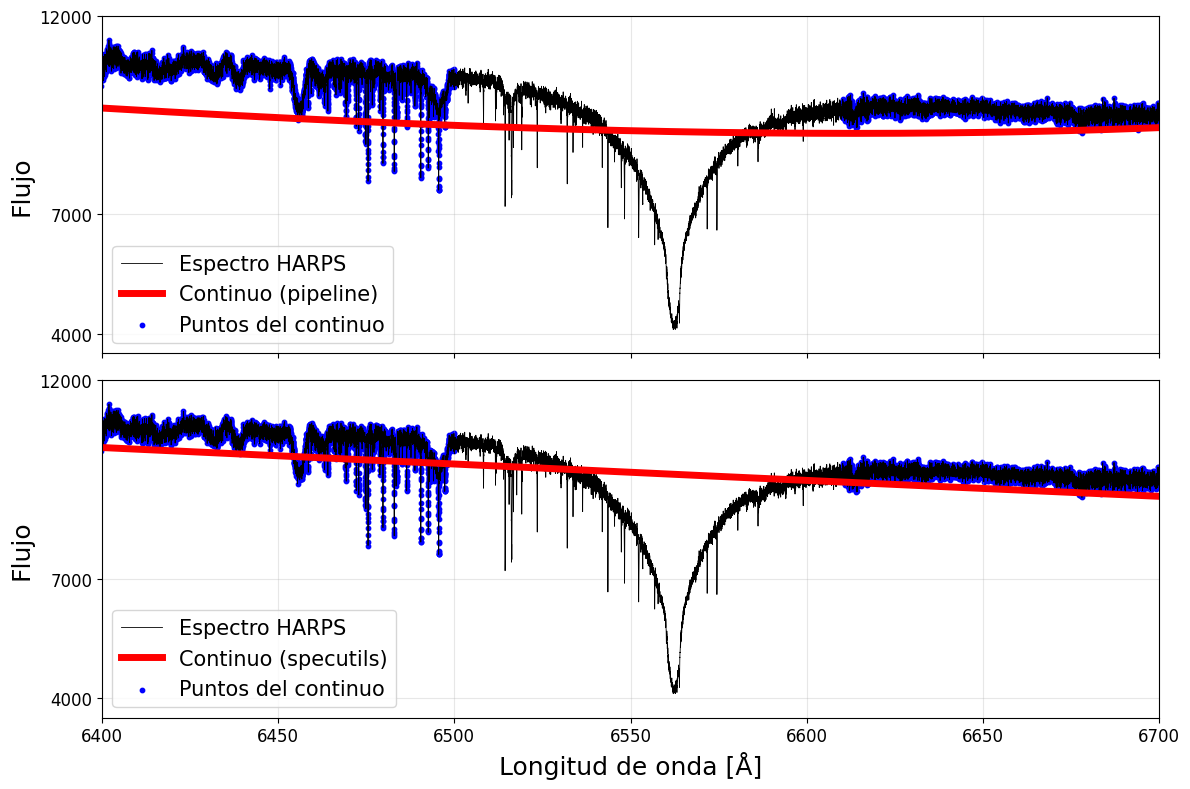

In [ ]:

regions = [(5400, 6500), (4930, 5270), (4400, 4790), (4010, 4070), (3790, 3920), (6610, 6860),(4150, 4270)]



spec_HARPS = "archive\ADP.2023-06-07T01_04_24.737.fits" #"archive/ADP.2018-03-28T01_03_35.950.fits"

hdul = fits.open(spec_HARPS)
data = hdul[1].data
wavelength = data[0][0] 
flux       = data[0][1]
Date       = hdul[0].header["DATE"]
hdul.close()

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

cont_poly = ajustar_continuo(wavelength, flux, regions, method="pipeline", grado=8, ax=axs[0])
cont_spec = ajustar_continuo(wavelength, flux, regions, method="specutils", s=1e7, ax=axs[1])

axs[0].set_xlabel("")

axs[0].set_xlim(6400,6700)
axs[1].set_xlim(6400,6700)


axs[0].set_ylim(3500,12000)
axs[1].set_ylim(3500,12000)

axs[0].set_yticks([12000, 7000, 4000])
axs[1].set_yticks([12000, 7000, 4000])
plt.tight_layout()
plt.savefig("Imagenes/Comp continuos P-RV")
plt.show()



## Todo lo anterior pero ahora con funciones para automatizar

### FUNCION PARA PROCESAR TODOS LOS ESPECTROS


In [ ]:

def process_harps_spectra(fits_list, template_file, poly_order=8):
    """
    fits_list: lista de paths a archivos HARPS
    template_file: path al archivo del template espectral
    poly_order: orden del polinomio para ajuste al continuo
    """

    # ---- Procesar template ----
    #hdul_tpl = fits.open(template_file)
    #data_tpl = hdul_tpl[1].data
    #hdul_tpl.close()
    #wavelength_tpl = np.array([row[0] for row in data_tpl])
    #flux_tpl = np.array([row[1] for row in data_tpl])


   
    #file = "Templates\hres_Spectrum_FeH3_id191_teff8000.0_logg4.00.dat.xml"
    #votable = parse_single_table(file)
    #data = votable.array
    #wavelength_tpl = data['WAVELENGTH']    # o 'col1', 'LAMBDA', etc.
    #flux_tpl = data['FLUX']                # o 'col2', 'SPEC_FLUX', etc.
   
    with fits.open("Templates/R_50.0_6750_40_p02p00.ms.fits") as hdul_tpl:
        
        flux_tpl = np.asarray(hdul_tpl[0].data, float)
        hdul_tpl.close()
  


    n_pix = len(flux_tpl)
    lam_min = 4000.0   # Å
    lam_max = 7000.0   # Å
    step = (lam_max - lam_min) / (n_pix - 1)
    wavelength_tpl = lam_min + np.arange(n_pix) * step

    regions_obs = [(5400, 6500), (4930, 5270), (4400, 4790), (4010, 4070), (3790, 3920),(6610, 6860),(4150, 4270)]
    regions_templ = [(3810, 3820), (3855, 3870), (3910, 3920), (3940, 3960) , (3990, 4090), (4120, 4320) , (4400,4800) , (5000, 5750), (6000,6400), (6750, 8000)]


    wavelength_mask_template = (wavelength_tpl > 4700) & (wavelength_tpl < 5050)
    wavelength_tpl = wavelength_tpl[wavelength_mask_template]
    flux_tpl = flux_tpl[wavelength_mask_template]


    cont_tpl = fit_continuum(wavelength_tpl, flux_tpl, regions_templ, method="polinomio", grado=1, s = 0.1)
    flux_tpl_norm = flux_tpl / cont_tpl


    # ---- Procesar cada espectro ----
    harps_dict = {}
    for path in fits_list:
        hdul = fits.open(path)
        data = hdul[1].data
        Date = hdul[0].header["DATE"]
        hdul.close()

        wavelength = np.array(data[0][0])
        flux = np.array(data[0][1])

        wavelength_mask_harps = (wavelength > 4700) & (wavelength < 5050)
        wavelength = wavelength[wavelength_mask_harps]
        flux = flux[wavelength_mask_harps]

        # Ajuste al continuo
        cont_obs = fit_continuum(wavelength, flux, regions_obs, method="polinomio", grado = 1, s=0.1)
        flux_norm = flux / cont_obs

        # Guardar en dict
        harps_dict[path] = [wavelength, flux_norm, Date]
        
    return (wavelength_tpl, flux_tpl_norm), harps_dict




### FUNCION PARA EXTRAER LA CCF DE TODOS LOS ESPECTROS

In [ ]:
from PyAstronomy import pyasl
from scipy.interpolate import interp1d
import numpy as np




def crosscorr_all(harps_dict, wavelength_tpl, flux_tpl_norm):
    """
    harps_dict: dict con {path: [wavelength, flux_norm, DATE]}
    wavelength_tpl, flux_tpl_norm: template normalizado
    rvmin, rvmax, drv: rango y paso de velocidades radiales para crosscorr
    skipedge: número de píxeles a ignorar en los bordes

    Retorna:
        dict con {path: [rv, cc]}
    """
    cc_dict = {}
    for path, (wave_obs, flux_obs, date) in harps_dict.items():
  
        interp_tpl = interp1d(wavelength_tpl, flux_tpl_norm,
                              kind='linear', bounds_error=False,
                               fill_value=np.nan)


        flux_tpl_interp = interp_tpl(wave_obs)

        mask = ~np.isnan(flux_tpl_interp)

  
        wave_common = wave_obs[mask]
        flux_obs_common = flux_obs[mask]
        flux_tpl_common = flux_tpl_interp[mask]
    
        # NO OCUPE LA INTERPOLACION
        rv, cc = pyasl.crosscorrRV(wave_obs,flux_obs, wavelength_tpl, flux_tpl_norm, -33-10, -33+10,0.01,skipedge=1000)

        #Est es la configuracion para template_sun.txt
        #rv, cc = pyasl.crosscorrRV(wave_common, 
        #                           flux_obs_common,
        #                            wave_common, 
        #                           flux_tpl_common, 
        #                            -89-2, -89+2, 0.001, skipedge=1000)
        cc_dict[path] = [rv, cc]
        print(f"{path}: v_r = {rv[np.argmax(cc)]} km/s")

    return cc_dict


### FUNCION QUE CALCULA EL ERROR Y RV MEJORADO

El profe en clases esta mostrando otro procedimiento.


Delta v= 2.5k/s Harps tiene un valor, LSF, casi siempore esta resuetla para varios elemntos de resulcion espectral.

Delta v = 0.6 k/s para los datos que tenemos.
Delta Lambda = 0.01




In [25]:
print(3e8*0.01/5000)

600.0


In [ ]:
def fit_ccf_all(cc_dict, harps_dict, window=10, poly_order=1):
    """
    cc_dict: dict con {path: [rv_array, cc_array]}
    harps_dict: dict con {path: [wavelength, flux_norm, DATE]}
    window: ventana para ajustar la gaussiana alrededor del máximo de la CCF
    poly_order: orden del polinomio para el fondo

    Retorna:
        dict con {path: [velocidad_radial, error_velocidad, DATE]}
    """
    results_dict = {}
    
    for path, (rv_array, cc_array) in cc_dict.items():
        # Obtener DATE correspondiente
        date = harps_dict[path][2]
        
        # Ajustar CCF y obtener velocidad radial y error
        #res = fit_ccf_weighted(rv_array, cc_array, window=window, poly_order=poly_order)
        # rv, cc: arrays que te devuelve tu crosscorr
         # drv: el paso de velocidad que usaste en la CCF (por ejemplo 0.001 km/s)
        res1 = fit_ccf(rv_array, cc_array)  
      
        # Guardar resultados
        results_dict[path] = [res1['v0'], res1['err_v0'], date]

        #res['v0']
        
        # Opcional: imprimir para seguimiento
        print(f"{path}: v_r = {res1['v0']:.2f} km/s ± {res1['err_v0']:.2f}, anterio = {rv_array[np.argmax(cc_array)]}")
    
    return results_dict


### CORRECION POR MOV HELIOCENTRICO Y BARICENTRICO

In [78]:
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.time import Time
import astropy.units as u

def corregir_velocidades_dict(cc_fit_dict, ra_deg=225.684717, dec_deg=-3.03035, observatorio='La Silla Observatory (ESO)'):
    """
    cc_fit_dict: dict con {path: [v_r, err_vr, DATE]}
    ra_deg, dec_deg: coordenadas de la estrella en grados
    observatorio: nombre del observatorio
    
    Retorna:
        dict con {path: [v_r_corrected, err_vr, DATE]}
    """
    coord = SkyCoord(ra=ra_deg*u.deg, dec=dec_deg*u.deg)
    location = EarthLocation.of_site(observatorio)
    
    corrected_dict = {}
    
    for path, (v_r, err_vr, date) in cc_fit_dict.items():
        obstime = Time(date)
        v_corr = coord.radial_velocity_correction(obstime=obstime, location=location)
        v_r_corrected = v_r + v_corr.to(u.km/u.s).value
        corrected_dict[path] = [v_r_corrected, err_vr, date]
        #print(f"Velocidad corregida: {v_r_corrected}, la correccion fue de {v_corr.to(u.km/u.s)}")
    
    return corrected_dict


In [28]:
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.time import Time
import astropy.units as u


location = EarthLocation.of_site('La Silla Observatory (ESO)')
ra_deg=225.684717
dec_deg=-3.03035
coord = SkyCoord(ra=ra_deg*u.deg, dec=dec_deg*u.deg)
date = "2018-03-27T04:08:02.174"
obstime = Time(date)
v_corr = coord.radial_velocity_correction(obstime=obstime, location=location)


print(v_corr.to(u.km/u.s))

18.513278266305132 km / s


In [96]:
import time
import os


start = time.time()
archivos = os.listdir("archive")
fits_list = ["archive/" + f for f in archivos if "ADP.2023-06" in f and f.endswith(".fits")]

end = time.time()
print(f"Tiempo para listar archivos: {end-start:.2f} s")


print(len(fits_list))
start = time.time()
(template_wave, template_flux), harps_data = process_harps_spectra(fits_list, "Templates/ATLAS-A_5272.fits")
end = time.time()
print(f"Tiempo para procesar espectros HARPS: {end-start:.2f} s")



start = time.time()
cc_results = crosscorr_all(harps_data, template_wave, template_flux)
end = time.time()
print(f"Tiempo para calcular CCF: {end-start:.2f} s")




Tiempo para listar archivos: 0.00 s
154
Tiempo para procesar espectros HARPS: 4.01 s
archive/ADP.2023-06-05T01_02_22.459.fits: v_r = -23.010000000003977 km/s
archive/ADP.2023-06-05T01_02_22.461.fits: v_r = -23.010000000003977 km/s
archive/ADP.2023-06-05T01_02_22.463.fits: v_r = -23.010000000003977 km/s
archive/ADP.2023-06-05T01_02_22.465.fits: v_r = -23.010000000003977 km/s
archive/ADP.2023-06-05T01_02_22.467.fits: v_r = -23.010000000003977 km/s
archive/ADP.2023-06-05T01_02_22.469.fits: v_r = -23.010000000003977 km/s
archive/ADP.2023-06-05T01_02_22.489.fits: v_r = -23.010000000003977 km/s
archive/ADP.2023-06-05T01_02_22.491.fits: v_r = -23.010000000003977 km/s
archive/ADP.2023-06-05T01_02_22.493.fits: v_r = -23.010000000003977 km/s
archive/ADP.2023-06-05T01_02_22.495.fits: v_r = -23.010000000003977 km/s
archive/ADP.2023-06-05T01_02_22.497.fits: v_r = -23.010000000003977 km/s
archive/ADP.2023-06-05T01_02_22.499.fits: v_r = -23.010000000003977 km/s
archive/ADP.2023-06-05T01_02_22.501.fit

KeyboardInterrupt: 

In [79]:
# =====================================
# 4️⃣ Ajuste de CCF y obtención de velocidad radial
# =====================================
start = time.time()
cc_fit_dict = fit_ccf_all(cc_results, harps_data, window=1, poly_order=1)
end = time.time()
print(f"Tiempo para ajustar CCF y obtener velocidades: {end-start:.2f} s")

# =====================================
# 5️⃣ Corrección de velocidades radiales
# =====================================
start = time.time()
cc_fit_corr_dict = corregir_velocidades_dict(cc_fit_dict)
end = time.time()
print(f"Tiempo para corregir velocidades radiales: {end-start:.2f} s")

archive/ADP.2023-06-05T01_02_22.459.fits: v_r = -25.20 km/s ± 2.62, anterio = -20.199999999999534
archive/ADP.2023-06-05T01_02_22.461.fits: v_r = -25.60 km/s ± 2.46, anterio = -20.59999999999954
archive/ADP.2023-06-05T01_02_22.463.fits: v_r = -25.80 km/s ± 2.30, anterio = -20.799999999999542
archive/ADP.2023-06-05T01_02_22.465.fits: v_r = -25.50 km/s ± 2.55, anterio = -20.499999999999538
archive/ADP.2023-06-05T01_02_22.467.fits: v_r = -25.50 km/s ± 2.37, anterio = -20.499999999999538
archive/ADP.2023-06-05T01_02_22.469.fits: v_r = -25.79 km/s ± 2.30, anterio = -20.799999999999542
archive/ADP.2023-06-05T01_02_22.489.fits: v_r = -25.50 km/s ± 2.50, anterio = -20.499999999999538
archive/ADP.2023-06-05T01_02_22.491.fits: v_r = -25.60 km/s ± 2.48, anterio = -20.59999999999954
archive/ADP.2023-06-05T01_02_22.493.fits: v_r = -25.70 km/s ± 2.59, anterio = -20.69999999999954
archive/ADP.2023-06-05T01_02_22.495.fits: v_r = -25.79 km/s ± 2.28, anterio = -20.799999999999542
archive/ADP.2023-06-05T

In [80]:
print(cc_fit_corr_dict)
def guardar_resultados_txt(cc_fit_corr_dict1, filename="vr_results.txt"):
    """
    Guarda los resultados de velocidad radial corregida en un archivo .txt
    Formato: path | vr_corr (km/s) | err_vr (km/s) | DATE
    """
    with open(filename, "w") as f:
        f.write("Archivo\tVR_corr \tError \tFecha\n")
        f.write("="*70 + "\n")
        for path, (vr_corr, err_vr, date) in cc_fit_corr_dict1.items():
            f.write(f"{path}\t{vr_corr:.4f}\t{err_vr:.4f}\t{date}\n")

    print(f"✅ Resultados guardados en '{filename}'")


# Uso:
guardar_resultados_txt(cc_fit_corr_dict, "vr_v5_ultimodia.txt")


{'archive/ADP.2023-06-05T01_02_22.459.fits': [-39.01820638195005, 2.616005560774423, '2023-06-04T05:27:41.800'], 'archive/ADP.2023-06-05T01_02_22.461.fits': [-39.42984613397866, 2.461166786019877, '2023-06-04T05:34:53.787'], 'archive/ADP.2023-06-05T01_02_22.463.fits': [-39.64239406141465, 2.296678205003567, '2023-06-04T05:42:05.769'], 'archive/ADP.2023-06-05T01_02_22.465.fits': [-39.35385974314001, 2.5526916717366506, '2023-06-04T05:49:17.754'], 'archive/ADP.2023-06-05T01_02_22.467.fits': [-39.36519895171505, 2.3653959187795977, '2023-06-04T05:56:29.757'], 'archive/ADP.2023-06-05T01_02_22.469.fits': [-39.66830330090342, 2.29965097155701, '2023-06-04T06:03:41.908'], 'archive/ADP.2023-06-05T01_02_22.489.fits': [-38.691261523298714, 2.499320864359193, '2023-06-04T00:01:04.341'], 'archive/ADP.2023-06-05T01_02_22.491.fits': [-38.8026103283098, 2.4808531237977447, '2023-06-04T00:08:16.858'], 'archive/ADP.2023-06-05T01_02_22.493.fits': [-38.91224821457208, 2.588242411206998, '2023-06-04T00:15

In [ ]:
import pandas as pd
from astropy.time import Time

ruta = "vr_v5_ultimodia.txt"

df = pd.read_csv(ruta, sep=r'\s+', comment='=', engine='python')

df["Fecha"] = [Time(f, format="isot", scale="utc").jd -2400000.5 for f in df["Fecha"]]

print(df["Fecha"][0])

60099.22756712977


## Ploteamos los radial velocity

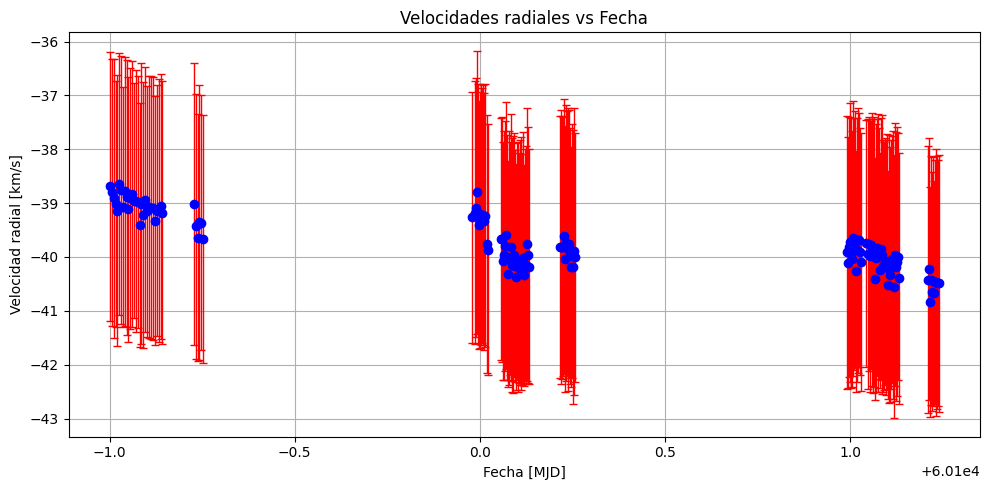

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.errorbar(df['Fecha'], df['VR_corr'], yerr=df['Error'],
             fmt='o', color='blue', ecolor='red', elinewidth=1, capsize=3)

plt.xlabel("Fecha [MJD]")
plt.ylabel("Velocidad radial [km/s]")
plt.title("Velocidades radiales vs Fecha")
plt.grid(True)
plt.tight_layout()
plt.show()


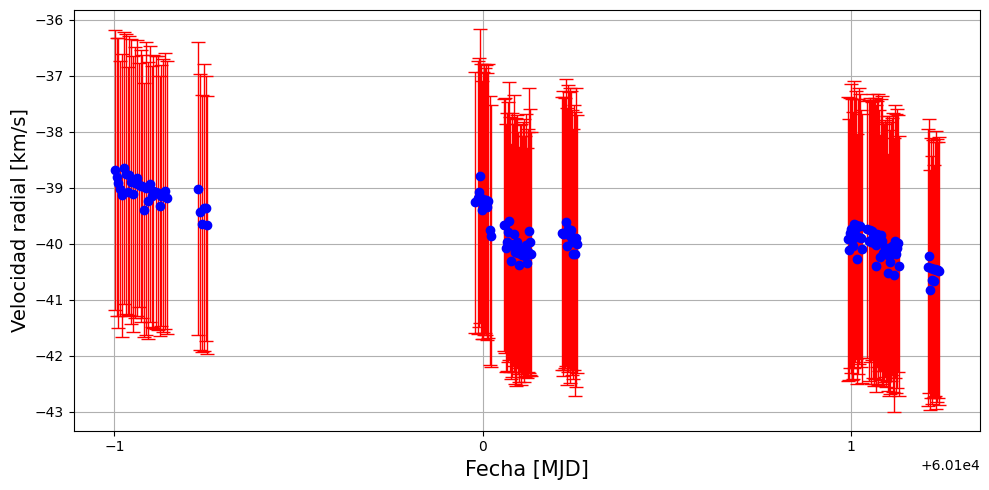

In [ ]:
import matplotlib.pyplot as plt

start_file = "archive/ADP.2023-06-05T01_02_22.459.fits"
end_file   = "archive/ADP.2023-06-07T01_04_24.749.fits"

# Filtrar el DataFrame
mask = (df['Archivo'] >= start_file) & (df['Archivo'] <= end_file)
df_filtered = df[mask]

# Graficar
plt.figure(figsize=(10,5))
plt.errorbar(df_filtered['Fecha'], df_filtered['VR_corr'], yerr=df_filtered['Error'],
             fmt='o', color='blue', ecolor='red', elinewidth=1, capsize=5)

plt.xlabel("Fecha [MJD]", fontsize=15)
plt.ylabel("Velocidad radial [km/s]", fontsize=14)
plt.xticks([6.01e4,6.01e4+1,6.01e4-1])
plt.grid(True)
plt.tight_layout()
plt.show()


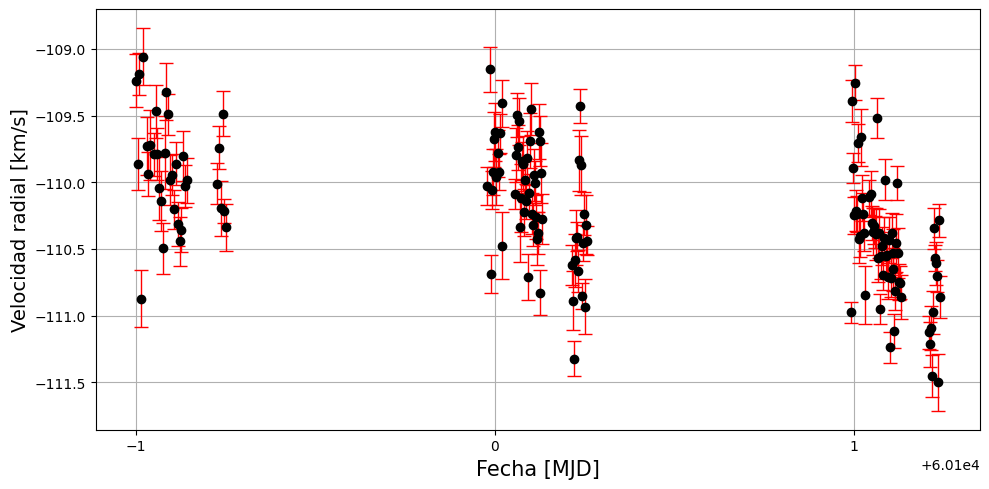

In [ ]:
import pandas as pd
from astropy.time import Time
import matplotlib.pyplot as plt

ruta = "Textos/vr_corr.txt"


df = pd.read_csv(
    ruta,
    sep=r'\s+',         
    comment='=',       
    engine='python'     
)

df["Fecha"] = [Time(f, format="isot", scale="utc").jd-2400000.5 for f in df["Fecha"]]



start_file = "archive/ADP.2023-06-05T01_02_22.459.fits"
end_file   = "archive/ADP.2023-06-07T01_04_24.749.fits"

# Filtrar el DataFrame
mask = (df['Archivo'] >= start_file) & (df['Archivo'] <= end_file) & (df["VR_corr"]<-109) 
df = df[mask]
mask_error = (df["Error"]>=0.00) & (df["Error"] <100)
df = df[mask_error] 
# Graficar
plt.figure(figsize=(10,5))
plt.errorbar(df['Fecha'], df['VR_corr'], yerr=df['Error'],
             fmt='o', color='black', ecolor='red', elinewidth=1, capsize=5)

plt.xlabel("Fecha [MJD]", fontsize=15)
plt.ylabel("Velocidad radial [km/s]", fontsize=14)
plt.xticks([6.01e4,6.01e4+1,6.01e4-1])
plt.grid(True)
plt.tight_layout()
plt.show()


2.0545


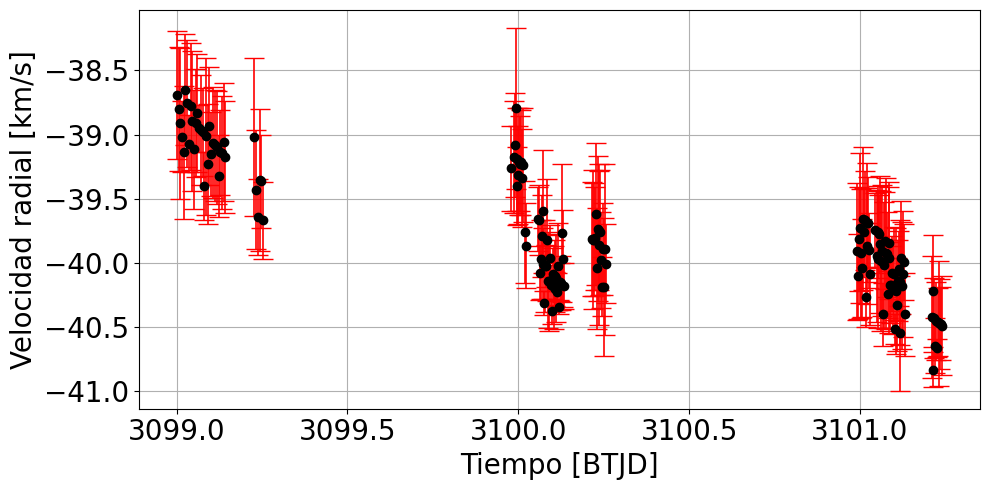

In [ ]:
import pandas as pd
from astropy.time import Time
import matplotlib.pyplot as plt
# Ruta al archivo .txt
ruta = "vr_v5_ultimodia.txt"

# Leer el archivo, saltando la línea de separación con ===
df = pd.read_csv(
    ruta,
    sep=r'\s+',          
    comment='=',        
    engine='python'      
)

df["Fecha"] = [Time(f, format="isot", scale="utc").jd-2457000.5 for f in df["Fecha"]]
start_file= "archive/ADP.2023-06-05T01_02_22.459.fits"
end_file ="archive/ADP.2023-06-07T01_04_24.749.fits"



# Filtrar el DataFrame
mask = (df['Archivo'] >= start_file) & (df['Archivo'] <= end_file)
df = df[mask]
print(min(df["Error"]))
df["Error"] = [err - 2 for err in df["Error"] if err >2]



plt.figure(figsize=(10,5))
plt.errorbar(df['Fecha'], df['VR_corr'], yerr=df['Error'],
             fmt='o', color='black', ecolor='red', elinewidth=1.2, capsize=7)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Tiempo [BTJD]", fontsize=20)
plt.ylabel("Velocidad radial [km/s]", fontsize=20)
#plt.xticks([6.01e4,6.01e4+1,6.01e4-1])
plt.grid(True)

plt.tight_layout()

plt.savefig("Imagenes/VR_ultimodia.png")
plt.show()

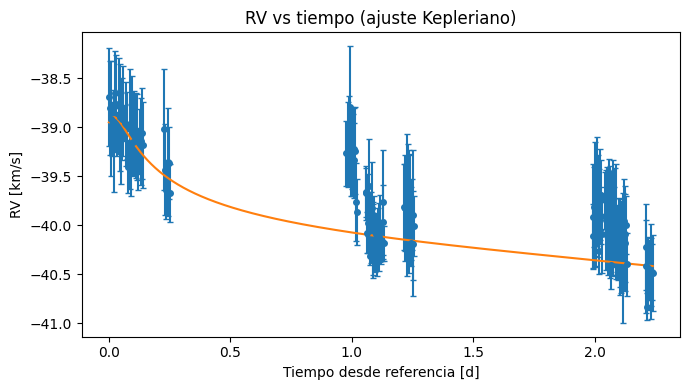

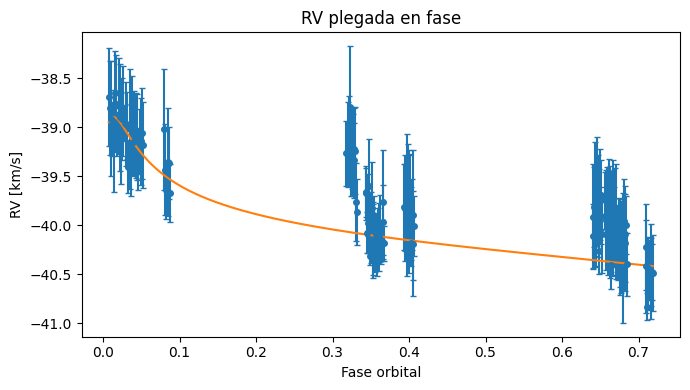

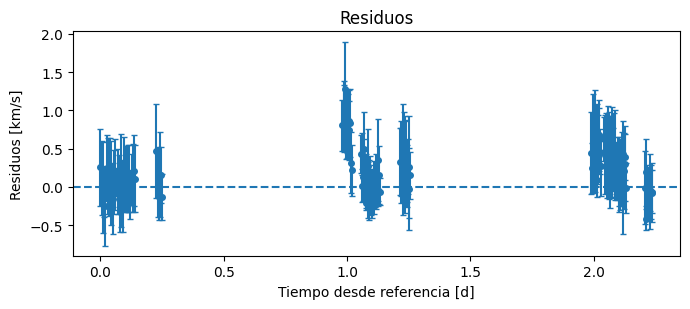

{'P_days': 3.1481101996727805, 'P_err': 14.914044896424107, 'K_kms': 0.8277199071757235, 'K_err': 2.5690553325530785, 'e': 0.7638967406694069, 'e_err': 1.1664684089052302, 'omega_rad': -0.8920459564934031, 'omega_err': 3.261262959586164, 'T0_days_since_ref': -0.023924312747501987, 'T0_err': 0.08628104449369296, 'gamma_kms': -40.11917468816477, 'gamma_err': 2.7214435819794027}
{'a1_sin_i_AU': 0.00015457147776404628, 'm2_sin_i_Mjup': 6.114633087715251}


<Figure size 640x480 with 0 Axes>

KeyError: 't_fit'

In [111]:
import pandas as pd
from fit_keplerian_rv import fit_keplerian



res = fit_keplerian(df, M_star_solar=2,period_guess=2.7)  # pon aquí la masa estelar si la conoces
print(res['params'])
print(res['derived'])



plt.tight_layout()
plt.show()


import matplotlib.pyplot as plt



# Curva Kepleriana ajustada
plt.plot(res['t_fit'], res['rv_fit'], '-', color='crimson', label='Modelo Kepleriano')

plt.xlabel("Tiempo (días desde referencia)")
plt.ylabel("Velocidad radial (km/s)")
plt.legend()
plt.show()



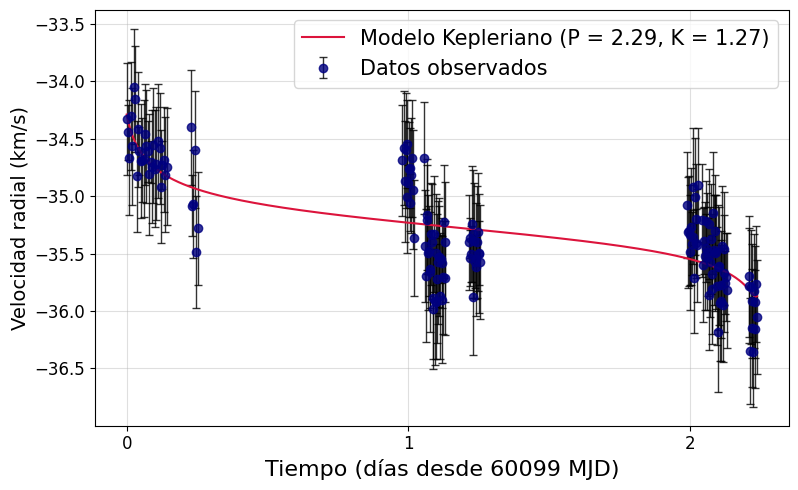

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===============================
# 🔹 Función del modelo Kepleriano
# ===============================
def keplerian_model(t, P, K, e, omega, T0, gamma):
    """
    Calcula la velocidad radial (km/s) en tiempos t (en días)
    para los parámetros Keplerianos dados.
    """
    # Anomalía media
    M = 2 * np.pi * (t - T0) / P
    M = np.mod(M, 2 * np.pi)

    # Resolver ecuación de Kepler (M = E - e sin E)
    E = M.copy()
    for _ in range(100):
        E -= (E - e*np.sin(E) - M) / (1 - e*np.cos(E))

    # Anomalía verdadera
    nu = 2 * np.arctan2(np.sqrt(1+e)*np.sin(E/2), np.sqrt(1-e)*np.cos(E/2))

    # Velocidad radial
    V = gamma + K * (np.cos(nu + omega) + e*np.cos(omega))
    return V


# =================================
# 🔹 Generar y graficar la curva
# =================================

# Extraer parámetros del resultado del ajuste
params = res['params']
P      = params['P_days']
K      = params['K_kms']
e      = params['e']
omega  = params['omega_rad']
T0     = params['T0_days_since_ref']
gamma  = params['gamma_kms']

# Convertir fechas del DataFrame a días (si están en MJD)
t_obs = df["Fecha"].values.astype(float)  # en MJD
t_ref = np.min(t_obs)                     # referencia (día mínimo)
t_days = t_obs - t_ref                    # días desde referencia

rv_obs  = df["VR_corr"].values
err_obs = df["Error"].values

# Curva modelo (densidad 500 puntos)
t_fit = np.linspace(np.min(t_days), np.max(t_days), 500)
rv_fit = keplerian_model(t_fit, P, K, e, omega, T0, gamma)

# =================================
# 🔹 Plot de resultados
# =================================
plt.figure(figsize=(8,5))
plt.errorbar(t_days, rv_obs, yerr=err_obs, fmt='o', color='navy', label='Datos observados', alpha=0.8,
             capsize=3, elinewidth=1, ecolor="black")
plt.plot(t_fit, rv_fit, '-', color='crimson',
          label=f'Modelo Kepleriano (P = {P.round(2)}, K = {K.round(2)})')


plt.xlabel(f"Tiempo (días desde {int(t_obs[0])} MJD)", fontsize=16)
plt.ylabel("Velocidad radial (km/s)", fontsize=14)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.4)
plt.xticks([0,1,2], fontsize=12)

plt.tight_layout()
plt.savefig("Imagenes/velocidadeholaholahola")
plt.yticks(fontsize=12)

plt.show()


C:\Users\Maxlo\AppData\Local\Temp\ipykernel_22676\416042341.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clipped = df.groupby('Dia', group_keys=False).apply(sigma_clip_day)
C:\Users\Maxlo\AppData\Local\Temp\ipykernel_22676\416042341.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_daily = df_clipped.groupby('Dia').apply(


ValueError: Se requieren al menos 5 puntos para un ajuste Kepleriano razonable.

In [ ]:
df_fit

,Archivo,VR_corr,Error,Fecha
0,1970-01-01,-110.273482,0.172637,1970-01-01T00:00:00


In [ ]:
from astropy.table import Table
tbl = Table.read("data/reduced/2023-06-04/archivo.tbl", format="ascii")
print(tbl)
